<a href="https://colab.research.google.com/github/Series-Parallel/Machine_in_Learning/blob/main/KnnOnImdbDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Objective of this programming:

The dataset is of IMDB rating for 50k movies alright. The thing we have to do here is that, to predict the review is considered to be positive or negative. This prediction will be done by the machine. So, we need to train the machine by splitiing the dataset into 3. First, will be training. Second will be for cross validation and third, will be for testing of the model. Its that simple. Finally, we will use the KNN to predict the class of the review (posiitive or negative). In training we will use bag of words to make machine understand which words will be considered to be positive or negative and that way it will be able to predict the class of the review.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
data = pd.read_csv("IMDB Dataset.csv")
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Cleaning the data

In [2]:
data['review'] = data['review'].str.replace(r'<br\s*/?>', '', regex=True)

In [3]:
print(data['review'].head(10))

0    One of the other reviewers has mentioned that ...
1    A wonderful little production. The filming tec...
2    I thought this was a wonderful way to spend ti...
3    Basically there's a family where a little boy ...
4    Petter Mattei's "Love in the Time of Money" is...
5    Probably my all-time favorite movie, a story o...
6    I sure would like to see a resurrection of a u...
7    This show was an amazing, fresh & innovative i...
8    Encouraged by the positive comments about this...
9    If you like original gut wrenching laughter yo...
Name: review, dtype: object


In [4]:
print("Missing values before cleaning:")
print(data.isnull().sum())

Missing values before cleaning:
review       0
sentiment    0
dtype: int64


In [5]:
valid_sentiments = ['positive', 'negative']
invalid_rows = data[~data['sentiment'].isin(valid_sentiments)]
print(f"Invalid rows in sentiment column:\n{invalid_rows}")

Invalid rows in sentiment column:
Empty DataFrame
Columns: [review, sentiment]
Index: []


In [6]:
data = data[data['sentiment'].isin(valid_sentiments)]

In [7]:
print("\nMissing values after cleaning:")
print(data.isnull().sum())
print("\nShape of data after removing invalid rows:", data.shape)


Missing values after cleaning:
review       0
sentiment    0
dtype: int64

Shape of data after removing invalid rows: (50000, 2)


### Traning the model

In [8]:
X = data['review'].values
Y = data['sentiment'].values

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)

In [10]:
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33)

In [11]:
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

(22445,) (22445,)
(11055,) (11055,)
(16500,) (16500,)


In [12]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(X_train)

X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)

In [13]:
print("After vectorization")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)

After vectorization
(22445, 74109) (22445,)
(11055, 74109) (11055,)
(16500, 74109) (16500,)


### Applying KNN

ok now models knows the vocab that means it can make sentences now XD.
So, we can apply KNN to it and it will try to get similar words in neighbours and that way we can get our knn algorithm !

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [15]:
train_auc = []
cv_auc = []
K = [1, 5, 10 , 15, 21, 31, 41, 51]

for i in K:
  neigh = KNeighborsClassifier(n_neighbors=i)
  neigh.fit(X_train_bow, y_train)

  y_train_pred = neigh.predict_proba(X_train_bow)[:,1]
  y_cv_pred = neigh.predict_proba(X_cv_bow)[:,1]

  train_auc.append(roc_auc_score(y_train, y_train_pred))
  cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

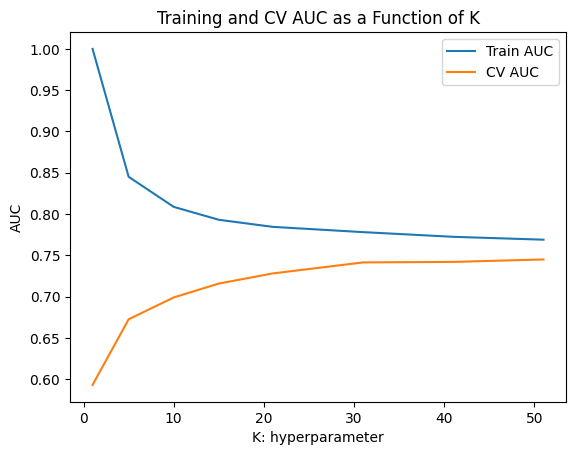

In [16]:
plt.plot(K, train_auc, label="Train AUC")
plt.plot(K, cv_auc, label="CV AUC")
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("Training and CV AUC as a Function of K")
plt.show()

In [17]:
best_k = 31

In [18]:
from sklearn.metrics import roc_curve, auc

In [19]:
neigh = KNeighborsClassifier(n_neighbors=best_k)
neigh.fit(X_train_bow, y_train)

KNeighborsClassifier(n_neighbors=31)

### **changing postive/negative to 1/-1 respectively**
forgot to do this earlier

In [20]:
print(data['sentiment'].unique())

['positive' 'negative']


In [21]:
data['sentiment'] = data['sentiment'].map({'positive': 1, 'negative': -1})
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. The filming tec...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,-1
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [22]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train_bow)[:,1], pos_label='positive')
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test_bow)[:,1], pos_label='positive')

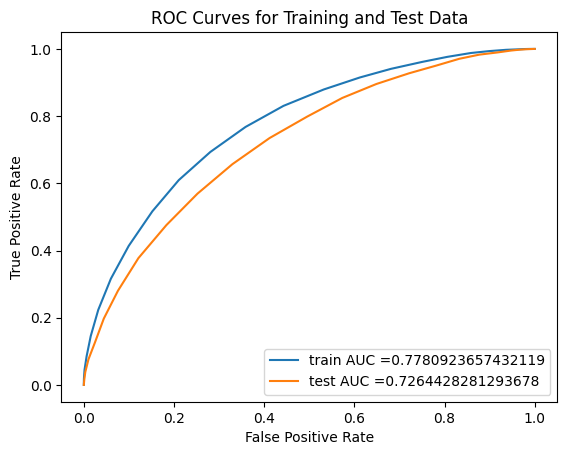

In [23]:
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Training and Test Data")
plt.show()

In [24]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(X_train_bow)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(X_test_bow)))

Train confusion matrix
[[6236 4956]
 [1907 9346]]
Test confusion matrix
[[4137 4058]
 [1674 6631]]


## Dimensionality Reduction

now we will do the dimensionality reduction so that we can plot the knn algorithm in 2D OR 3D.

In [25]:
from sklearn.decomposition import TruncatedSVD, PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [26]:
svd = TruncatedSVD(n_components=50, random_state=42)
X_train_reduced = svd.fit_transform(X_train_bow)

In [27]:
pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train_reduced)

In [28]:
pca_df = pd.DataFrame(X_train_pca, columns=['PCA-1', 'PCA-2'])
pca_df['sentiment'] = y_train

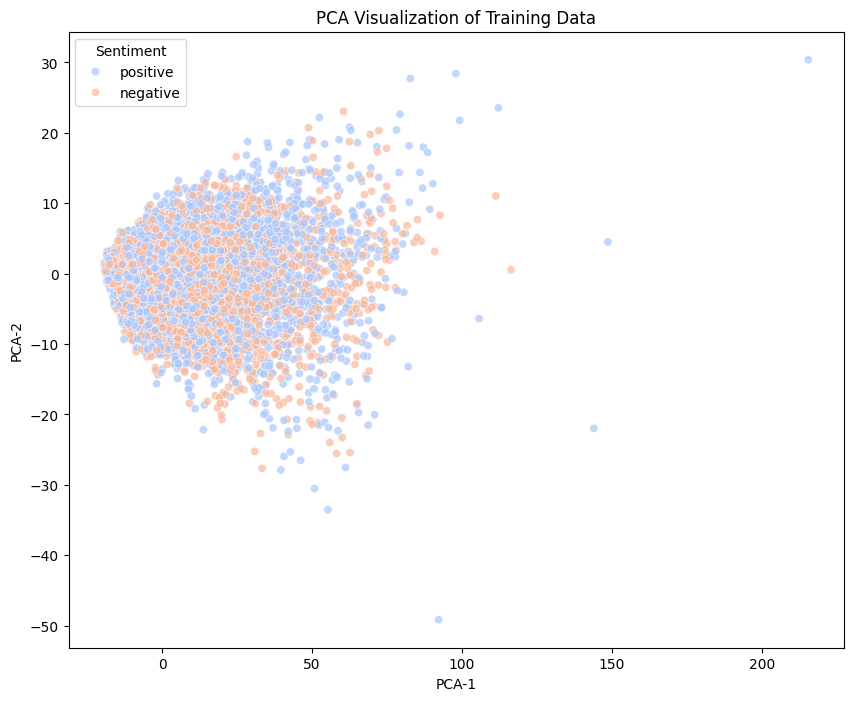

In [29]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA-1', y='PCA-2', hue='sentiment', palette='coolwarm', data=pca_df, alpha=0.7)
plt.title('PCA Visualization of Training Data')
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.legend(title='Sentiment')
plt.show()

## Predicting the class for new query

In [35]:
def predict_sentiment(review, vectorizer, model):
  review_bow = vectorizer.transform([review])
  predicted_sentiment = model.predict(review_bow)[0]
  predicted_prob = model.predict_proba(review_bow)[0]
  sentiment_label = "Positive" if predicted_sentiment == 1 else "Negative"
  probabilities = {"Positive": predicted_prob[1], "Negative": predicted_prob[0]}
  return sentiment_label, probabilities

In [36]:
new_review = "The movie was absolutely fantastic, with amazing acting and a gripping plot!"
sentiment, probabilities = predict_sentiment(new_review, vectorizer, neigh)
print("Predicted Sentiment:", sentiment)
print("Prediction Probabilities:", probabilities)

Predicted Sentiment: Negative
Prediction Probabilities: {'Positive': 0.7419354838709677, 'Negative': 0.25806451612903225}
